#  Imports

In [1]:
import os
# --- Environment (must be set before importing jax) ---
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import jax
import mmml
import numpy as np
import matplotlib.pyplot as plt
print(jax.devices())
data = np.load("dataset1.npz", allow_pickle=True)
data.keys()

[CudaDevice(id=0)]


KeysView(NpzFile 'dataset1.npz' with keys: R, Z, D, Ef, E)

(array([1.000e+00, 2.000e+00, 4.000e+00, 2.200e+01, 1.100e+02, 3.610e+02,
        1.406e+03, 5.138e+03, 2.812e+03, 1.440e+02]),
 array([-9.02483342, -7.82961667, -6.63439991, -5.43918315, -4.24396639,
        -3.04874964, -1.85353288, -0.65831612,  0.53690063,  1.73211739,
         2.92733415]),
 <BarContainer object of 10 artists>)

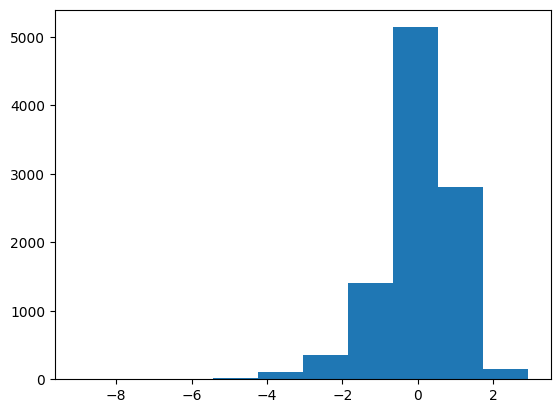

In [2]:
plt.hist(data["E"])

# Training

In [5]:
from training import *

# Option 1: Use all defaults
args = get_args()

# Option 2: Override specific parameters
args = get_args(
    data="data-full.npz",
    features=32,
    max_degree=4,
    num_iterations=2,
    num_basis_functions=16,
    cutoff=10.0,
    num_train=800,
    num_valid=100,
    num_epochs=200,
    learning_rate=0.001,
    batch_size=50,
    clip_norm=100.0,
    ema_decay=0.5,
    early_stopping_patience=None,
    early_stopping_min_delta=0.0,
    reduce_on_plateau_patience=5,
    reduce_on_plateau_cooldown=5,
    reduce_on_plateau_factor=0.9,
    reduce_on_plateau_rtol=1e-4,
    reduce_on_plateau_accumulation_size=5,
    reduce_on_plateau_min_scale=0.01,
    energy_weight=1.0,
    forces_weight=1000.0,
    dipole_weight=20.0,
    dipole_field_coupling=False,
    field_scale=0.001,
    restart=False,
)

# Print arguments to verify
print("Arguments:")
for arg in vars(args):
    print(f"  {arg}: {getattr(args, arg)}")

# Then use args as before - the rest of your code works the same way
data_key, train_key = jax.random.split(jax.random.PRNGKey(0), 2)
dataset = np.load(args.data, allow_pickle=True)
train_data, valid_data = prepare_datasets(
    data_key, num_train=args.num_train, num_valid=args.num_valid, dataset=dataset
)

print("\nPrepared data shapes:")
print(f"  train atomic_numbers: {train_data['atomic_numbers'].shape}")
print(f"  train positions:      {train_data['positions'].shape}")
print(f"  train electric_field: {train_data['electric_field'].shape}")
print(f"  train energies:       {train_data['energies'].shape}")
print(f"  train forces:        {train_data['forces'].shape}")


ValueError: Unknown argument: restart

In [4]:
params = main(args)

Arguments:
  data: data-full.npz
  features: 32
  max_degree: 4
  num_iterations: 2
  num_basis_functions: 16
  cutoff: 10.0
  num_train: 800
  num_valid: 100
  num_epochs: 200
  learning_rate: 0.001
  batch_size: 50
  clip_norm: 100.0
  ema_decay: 0.5
  early_stopping_patience: None
  early_stopping_min_delta: 0.0
  reduce_on_plateau_patience: 5
  reduce_on_plateau_cooldown: 5
  reduce_on_plateau_factor: 0.9
  reduce_on_plateau_rtol: 0.0001
  reduce_on_plateau_accumulation_size: 5
  reduce_on_plateau_min_scale: 0.01
  energy_weight: 1.0
  forces_weight: 1000.0
  dipole_weight: 20.0
  dipole_field_coupling: False
  field_scale: 0.001
Hyperparameters:
  features: 32
  max_degree: 4
  num_iterations: 2
  num_basis_functions: 16
  cutoff: 10.0
  num_train: 800
  num_valid: 100
  num_epochs: 200
  learning_rate: 0.001
  batch_size: 50
  clip_norm: 100.0
  ema_decay: 0.5
  early_stopping_patience: None
  early_stopping_min_delta: 0.0
  reduce_on_plateau_patience: 5
  reduce_on_plateau_coold

AttributeError: 'Namespace' object has no attribute 'restart'

# Evaluate

In [1]:

import jax
import mmml
import numpy as np
import matplotlib.pyplot as plt
print(jax.devices())

from evaluate import *
args = get_args(
    params="params-d0a93860-d514-4180-97e2-82bb2709b05b.json",
    data="data-full.npz",
    batch_size=100,
    output_dir="results"
)

[CudaDevice(id=0)]
CUDA graph capture is not supported in this JAX version
JAX devices: [CudaDevice(id=0)]
Dataset keys: ['R', 'Z', 'D', 'E', 'F', 'P', 'Ef']


In [ ]:
main(args)

Model Evaluation
Parameters: params-d0a93860-d514-4180-97e2-82bb2709b05b.json
Data: data-full.npz
Output directory: results
Batch size: 100

Loading dataset from data-full.npz...
Dataset keys: ['R', 'Z', 'D', 'E', 'F', 'P', 'Ef']
Dataset shapes:
  R: (10000, 1, 29, 3)
  Z: (10000, 29)
  D: (10000, 3)
  E: (10000,)
  F: (10000, 1, 29, 3)
  P: (10000, 1, 3, 3)
  Ef: (10000, 3)

Loading parameters from params-d0a93860-d514-4180-97e2-82bb2709b05b.json...
✓ Parameters loaded
✓ Found matching config file: config-d0a93860-d514-4180-97e2-82bb2709b05b.json

Loading model config from config-d0a93860-d514-4180-97e2-82bb2709b05b.json...
✓ Loaded model config from config-d0a93860-d514-4180-97e2-82bb2709b05b.json
  Config UUID: d0a93860-d514-4180-97e2-82bb2709b05b

Model configuration:
  max_degree: 4
  num_iterations: 2
  num_basis_functions: 16
  cutoff: 10.0
  max_atomic_number: 55
  include_pseudotensors: True
  features: 32
  dipole_field_coupling: False
  field_scale: 0.001

Preparing test dat